# Initialization

## Imports

In [1]:
import os 

import scanpy as sc
import numpy as np
import pandas as pd
import tqdm

## Config

In [2]:
TMS_DROPLET_RAW_FILENAME = '/home/amir/projects/theis-lab/data/tabula-muris-senis-droplet-official-raw-obj.h5ad'
TMS_FACS_RAW_FILENAME = '/home/amir/projects/theis-lab/data/tabula-muris-senis-facs-official-raw-obj.h5ad'

TMS_DROPLET_PROCESSED_WRITE_FILENAME = '/home/amir/projects/theis-lab/io/tabula_senis_droplet_processed.h5ad'
TMS_FACS_PROCESSED_WRITE_FILENAME = '/home/amir/projects/theis-lab/io/tabula_senis_facs_processed.h5ad'

SAMPLE_FRAC = 0.1
RANDOM_STATE = 123

# Helper functions

In [3]:
def hvg_batch(adata, batch_key=None, target_genes=2000, flavor='cell_ranger', n_bins=20, adataOut=False):
    """

    Method to select HVGs based on mean dispersions of genes that are highly 
    variable genes in all batches. Using a the top target_genes per batch by
    average normalize dispersion. If target genes still hasn't been reached, 
    then HVGs in all but one batches are used to fill up. This is continued 
    until HVGs in a single batch are considered.
    """
    
    adata_hvg = adata if adataOut else adata.copy()

    n_batches = len(adata_hvg.obs[batch_key].cat.categories)

    # Calculate double target genes per dataset
    sc.pp.highly_variable_genes(adata_hvg,
                                flavor=flavor, 
                                n_top_genes=target_genes,
                                n_bins=n_bins, 
                                batch_key=batch_key)

    nbatch1_dispersions = adata_hvg.var['dispersions_norm'][adata_hvg.var.highly_variable_nbatches >
                                                           len(adata_hvg.obs[batch_key].cat.categories)-1]
    
    nbatch1_dispersions.sort_values(ascending=False, inplace=True)

    if len(nbatch1_dispersions) > target_genes:
        hvg = nbatch1_dispersions.index[:target_genes]
    
    else:
        enough = False
        print(f'Using {len(nbatch1_dispersions)} HVGs from full intersect set')
        hvg = nbatch1_dispersions.index[:]
        not_n_batches = 1
        
        while not enough:
            target_genes_diff = target_genes - len(hvg)

            tmp_dispersions = adata_hvg.var['dispersions_norm'][adata_hvg.var.highly_variable_nbatches ==
                                                                (n_batches-not_n_batches)]

            if len(tmp_dispersions) < target_genes_diff:
                print(f'Using {len(tmp_dispersions)} HVGs from n_batch-{not_n_batches} set')
                hvg = hvg.append(tmp_dispersions.index)
                not_n_batches += 1

            else:
                print(f'Using {target_genes_diff} HVGs from n_batch-{not_n_batches} set')
                tmp_dispersions.sort_values(ascending=False, inplace=True)
                hvg = hvg.append(tmp_dispersions.index[:target_genes_diff])
                enough=True

    print(f'Using {len(hvg)} HVGs')

    if not adataOut:
        del adata_hvg
        return hvg.tolist()
    else:
        return adata_hvg[:,hvg].copy()

In [4]:
def subsample_selection(adata, study_key, frac=0.1, specific_cell_types=None, cell_type_key=None):
    studies = adata.obs[study_key].unique().tolist()
    if specific_cell_types and cell_type_key:
        subsampled_adata = adata[adata.obs[cell_type_key].isin(specific_cell_types)]
        other_adata = adata[~adata.obs[cell_type_key].isin(specific_cell_types)]
    else:
        subsampled_adata = None
    for study in tqdm.tqdm(studies):
        study_adata = other_adata[other_adata.obs[study_key] == study]
        n_samples = study_adata.shape[0]
        subsample_idx = np.random.choice(n_samples, int(frac * n_samples), replace=False)
        study_adata_subsampled = study_adata[subsample_idx, :]
        subsampled_adata = study_adata_subsampled if subsampled_adata is None else subsampled_adata.concatenate(study_adata_subsampled)
    return subsampled_adata

# Global Variables

In [5]:
cell_type_key = "cell_ontology_class"
tissue_key = "tissue"
age_key = "age"

# Droplet

In [6]:
adata_droplet = sc.read(TMS_DROPLET_RAW_FILENAME)
adata_droplet

AnnData object with n_obs × n_vars = 245389 × 20138
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'

In [7]:
adata_droplet = sc.pp.subsample(adata_droplet, fraction=SAMPLE_FRAC, random_state=RANDOM_STATE, copy=True)
adata_droplet

AnnData object with n_obs × n_vars = 24538 × 20138
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'

In [8]:
adata_droplet.X.min(), adata_droplet.X.max()

(0.0, 29297.0)

In [9]:
adata_droplet.obs['method_age'] = pd.Categorical(adata_droplet.obs['method'].str.cat(adata_droplet.obs['age'], sep=' - '))

In [10]:
sc.pp.normalize_total(adata_droplet, 
                      target_sum=1e4, 
                      exclude_highly_expressed=True, 
                      key_added='size_factors')
sc.pp.log1p(adata_droplet)

In [11]:
adata_droplet.X.min(), adata_droplet.X.max()

(0.0, 11.820554)

In [12]:
adata_droplet.write_h5ad(TMS_DROPLET_PROCESSED_WRITE_FILENAME)

In [13]:
# adata_droplet.obs[cell_type_key].value_counts()

In [14]:
# adata_droplet.obs[tissue_key].value_counts()

In [15]:
# adata_droplet.obs[age_key].value_counts()

In [16]:
# sc.pp.neighbors(adata_droplet)
# sc.tl.umap(adata_droplet)

In [17]:
# sc.pl.umap(adata_droplet, color=)

In [18]:
# del adata_droplet

# FACS

In [19]:
adata_facs = sc.read(TMS_FACS_RAW_FILENAME)
adata_facs

AnnData object with n_obs × n_vars = 110824 × 22966
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells'

In [20]:
adata_facs = sc.pp.subsample(adata_facs, fraction=SAMPLE_FRAC, random_state=RANDOM_STATE, copy=True)
adata_facs

AnnData object with n_obs × n_vars = 11082 × 22966
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells'

In [21]:
adata_facs.X.min(), adata_facs.X.max()

(0.0, 8518437.0)

In [22]:
sc.pp.normalize_total(adata_facs, target_sum=1e4, exclude_highly_expressed=True, key_added='size_factors')
sc.pp.log1p(adata_facs)

In [23]:
adata_facs.X.min(), adata_facs.X.max()

(0.0, 14.148694)

In [24]:
adata_facs.write_h5ad(TMS_FACS_PROCESSED_WRITE_FILENAME)

In [25]:
# adata_facs.obs[cell_type_key].value_counts()

In [26]:
# adata_facs.obs[tissue_key].value_counts()

In [27]:
# adata_facs.obs[age_key].value_counts()

In [28]:
# del adata_facs

In [27]:
adata = adata_droplet.concatenate(adata_facs)
adata

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'method_age', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'size_factors', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells-0', 'n_cells-1'

In [21]:
normalized_adata = sc.read("/home/mohsen/data/tabula_senis/tabula_senis_normalized_all_hvg.h5ad")
normalized_adata

AnnData object with n_obs × n_vars = 356213 × 5000 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'method_tissue', 'method_age', 'Tech'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [29]:
adata = adata[:, normalized_adata.var_names]
adata

View of AnnData object with n_obs × n_vars = 356213 × 5000 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'method_age', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'size_factors', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells-0', 'n_cells-1'

In [32]:
normalized_adata.obs.loc[adata.obs.index, 'size_factors'] = adata.obs['size_factors'].values

In [35]:
adata.X.max()

12.715832

In [36]:
normalized_adata.X = adata.X

In [37]:
normalized_adata.X.max()

12.715832

In [40]:
adata = sc.read("/home/mohsen/data/tabula_senis/tabula_senis_droplet_raw.h5ad").concatenate(sc.read("/home/mohsen/data/tabula_senis/tabula_senis_facs_raw.h5ad"))
adata

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells-0', 'n_cells-1'

In [41]:
adata = adata[:, normalized_adata.var_names.tolist()]
adata

View of AnnData object with n_obs × n_vars = 356213 × 5000 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells-0', 'n_cells-1'

In [42]:
adata.X.max()

9523593.0

In [43]:
normalized_adata.raw = adata

In [44]:
# Final Data
normalized_adata.write_h5ad("/home/mohsen/data/tabula_senis/tabula_senis_normalized_hvg_all_final.h5ad")

In [8]:
adata.X.min(), adata.X.max()

(0.0, 31922356.0)

In [9]:
sc.pp.normalize_total(adata, target_sum=1e4, exclude_highly_expressed=True)
sc.pp.log1p(adata)

In [10]:
adata.X.min(), adata.X.max()

(0.0, 15.383975)

In [11]:
import pandas as pd

In [12]:
adata.obs['method_tissue'] = pd.Categorical(adata.obs['method'].str.cat(adata.obs['tissue'], sep=' - '))
adata.obs['method_age'] = pd.Categorical(adata.obs['method'].str.cat(adata.obs['age'], sep=' - '))

In [13]:
adata.obs['Tech'] = 'Tabula Senis'
adata.obs.loc[adata.obs['age'] == '3m', 'Tech'] = 'Tabula Muris'

In [14]:
adata.obs['Tech'].value_counts()

Tabula Senis    266093
Tabula Muris     90120
Name: Tech, dtype: int64

In [15]:
sorted(adata.obs['method_tissue'].value_counts().index)

['droplet - Bladder',
 'droplet - Fat',
 'droplet - Heart_and_Aorta',
 'droplet - Kidney',
 'droplet - Large_Intestine',
 'droplet - Limb_Muscle',
 'droplet - Liver',
 'droplet - Lung',
 'droplet - Mammary_Gland',
 'droplet - Marrow',
 'droplet - Pancreas',
 'droplet - Skin',
 'droplet - Spleen',
 'droplet - Thymus',
 'droplet - Tongue',
 'droplet - Trachea',
 'facs - Aorta',
 'facs - BAT',
 'facs - Bladder',
 'facs - Brain_Myeloid',
 'facs - Brain_Non-Myeloid',
 'facs - Diaphragm',
 'facs - GAT',
 'facs - Heart',
 'facs - Kidney',
 'facs - Large_Intestine',
 'facs - Limb_Muscle',
 'facs - Liver',
 'facs - Lung',
 'facs - MAT',
 'facs - Mammary_Gland',
 'facs - Marrow',
 'facs - Pancreas',
 'facs - SCAT',
 'facs - Skin',
 'facs - Spleen',
 'facs - Thymus',
 'facs - Tongue',
 'facs - Trachea']

In [16]:
adata.obs['method_age'].value_counts()

droplet - 30m    55674
droplet - 3m     45602
droplet - 18m    44645
facs - 3m        44518
droplet - 24m    37660
droplet - 21m    35828
facs - 18m       34027
facs - 24m       31551
droplet - 1m     25980
facs - 21m         728
Name: method_age, dtype: int64

In [19]:
adata.write_h5ad(os.path.join(base_path, "./tabula_senis/tabula_senis_normalized_all.h5ad"))

In [13]:
# adata = adata[~adata.obs['tissue'].isin(['BAT', 'Fat', 'Heart_and_Aorta', 'Brain_Myeloid', 'Brain_Non-Myeloid', 
#                                          'Diaphragm', 'GAT', 'Heart', 'MAT', 'SCAT', 'Aorta'])]
# adata

In [14]:
# sorted(adata.obs['method_tissue'].value_counts().index)

In [15]:
# adata.write_h5ad("./data/tabula_senis/tabula_senis_normalized.h5ad")

# HVG on Tabula Senis shared with MCA

In [7]:
adata = sc.read("./data/tabula_senis/tabula_senis_shared_normalized_all.h5ad")

In [20]:
adata_hvg = hvg_batch(adata, "method_age", 5000, adataOut=True)
adata_hvg

/home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Using 1035 HVGs from full intersect set
Using 991 HVGs from n_batch-1 set
Using 572 HVGs from n_batch-2 set
Using 544 HVGs from n_batch-3 set
Using 724 HVGs from n_batch-4 set
Using 682 HVGs from n_batch-5 set
Using 452 HVGs from n_batch-6 set
Using 5000 HVGs


AnnData object with n_obs × n_vars = 356213 × 5000 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'method_tissue', 'method_age', 'Tech'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p'

In [21]:
adata_hvg.write_h5ad(os.path.join(base_path, "./tabula_senis/tabula_senis_normalized_all_hvg.h5ad"))

In [22]:
adata_hvg.obs['method_age'].value_counts()

droplet - 30m    55674
droplet - 3m     45602
droplet - 18m    44645
facs - 3m        44518
droplet - 24m    37660
droplet - 21m    35828
facs - 18m       34027
facs - 24m       31551
droplet - 1m     25980
facs - 21m         728
Name: method_age, dtype: int64

In [23]:
adata_hvg.obs['tissue'].value_counts()

Marrow               54737
Spleen               39552
Limb_Muscle          32722
Lung                 29758
Tongue               24415
Kidney               23480
Mammary_Gland        15577
Brain_Myeloid        13417
Thymus               13322
Bladder              11377
Trachea              11136
Large_Intestine      10198
Liver                10153
Heart                 9669
Pancreas              9585
Skin                  9314
Heart_and_Aorta       8613
Brain_Non-Myeloid     7249
Fat                   6777
SCAT                  3755
GAT                   3406
MAT                   3014
BAT                   2223
Diaphragm             1858
Aorta                  906
Name: tissue, dtype: int64

In [27]:
subsampled_adata = subsample_selection(adata_hvg, "tissue", 0.5, cell_type_key='method_age', specific_cell_types=['facs - 21m'])
subsampled_adata

100%|██████████| 25/25 [06:53<00:00, 16.54s/it]


AnnData object with n_obs × n_vars = 178464 × 5000 
    obs: 'FACS.selection', 'Tech', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [28]:
subsampled_adata.obs['method_age'].value_counts()

droplet - 30m    27631
droplet - 3m     22776
droplet - 18m    22254
facs - 3m        22209
droplet - 24m    19040
droplet - 21m    18086
facs - 18m       17151
facs - 24m       15640
droplet - 1m     12949
facs - 21m         728
Name: method_age, dtype: int64

In [ ]:
subsampled_adata.write_h5ad(os.path.join(base_path, "./tabula_senis/tabula_senis_normalized_subsampled_hvg.h5ad"))

... storing 'cell_ontology_class' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'free_annotation' as categorical
... storing 'method' as categorical
... storing 'method_age' as categorical
... storing 'method_tissue' as categorical
... storing 'mouse.id' as categorical
... storing 'sex' as categorical
... storing 'subtissue' as categorical
... storing 'tissue' as categorical
... storing 'tissue_free_annotation' as categorical


# Visualization

In [4]:
adata = sc.read("./data/tabula_senis/tabula_senis_normalized_hvg_subsampled.h5ad")
adata

AnnData object with n_obs × n_vars = 106861 × 2000 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [5]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/mohsen/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/mohsen/lib/py

In [8]:
adata = adata[~((adata.obs['tissue'].isin(['Lung', 'Liver'])) & (adata.obs['age'] != '3m'))]
adata

View of AnnData object with n_obs × n_vars = 96962 × 2000 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'

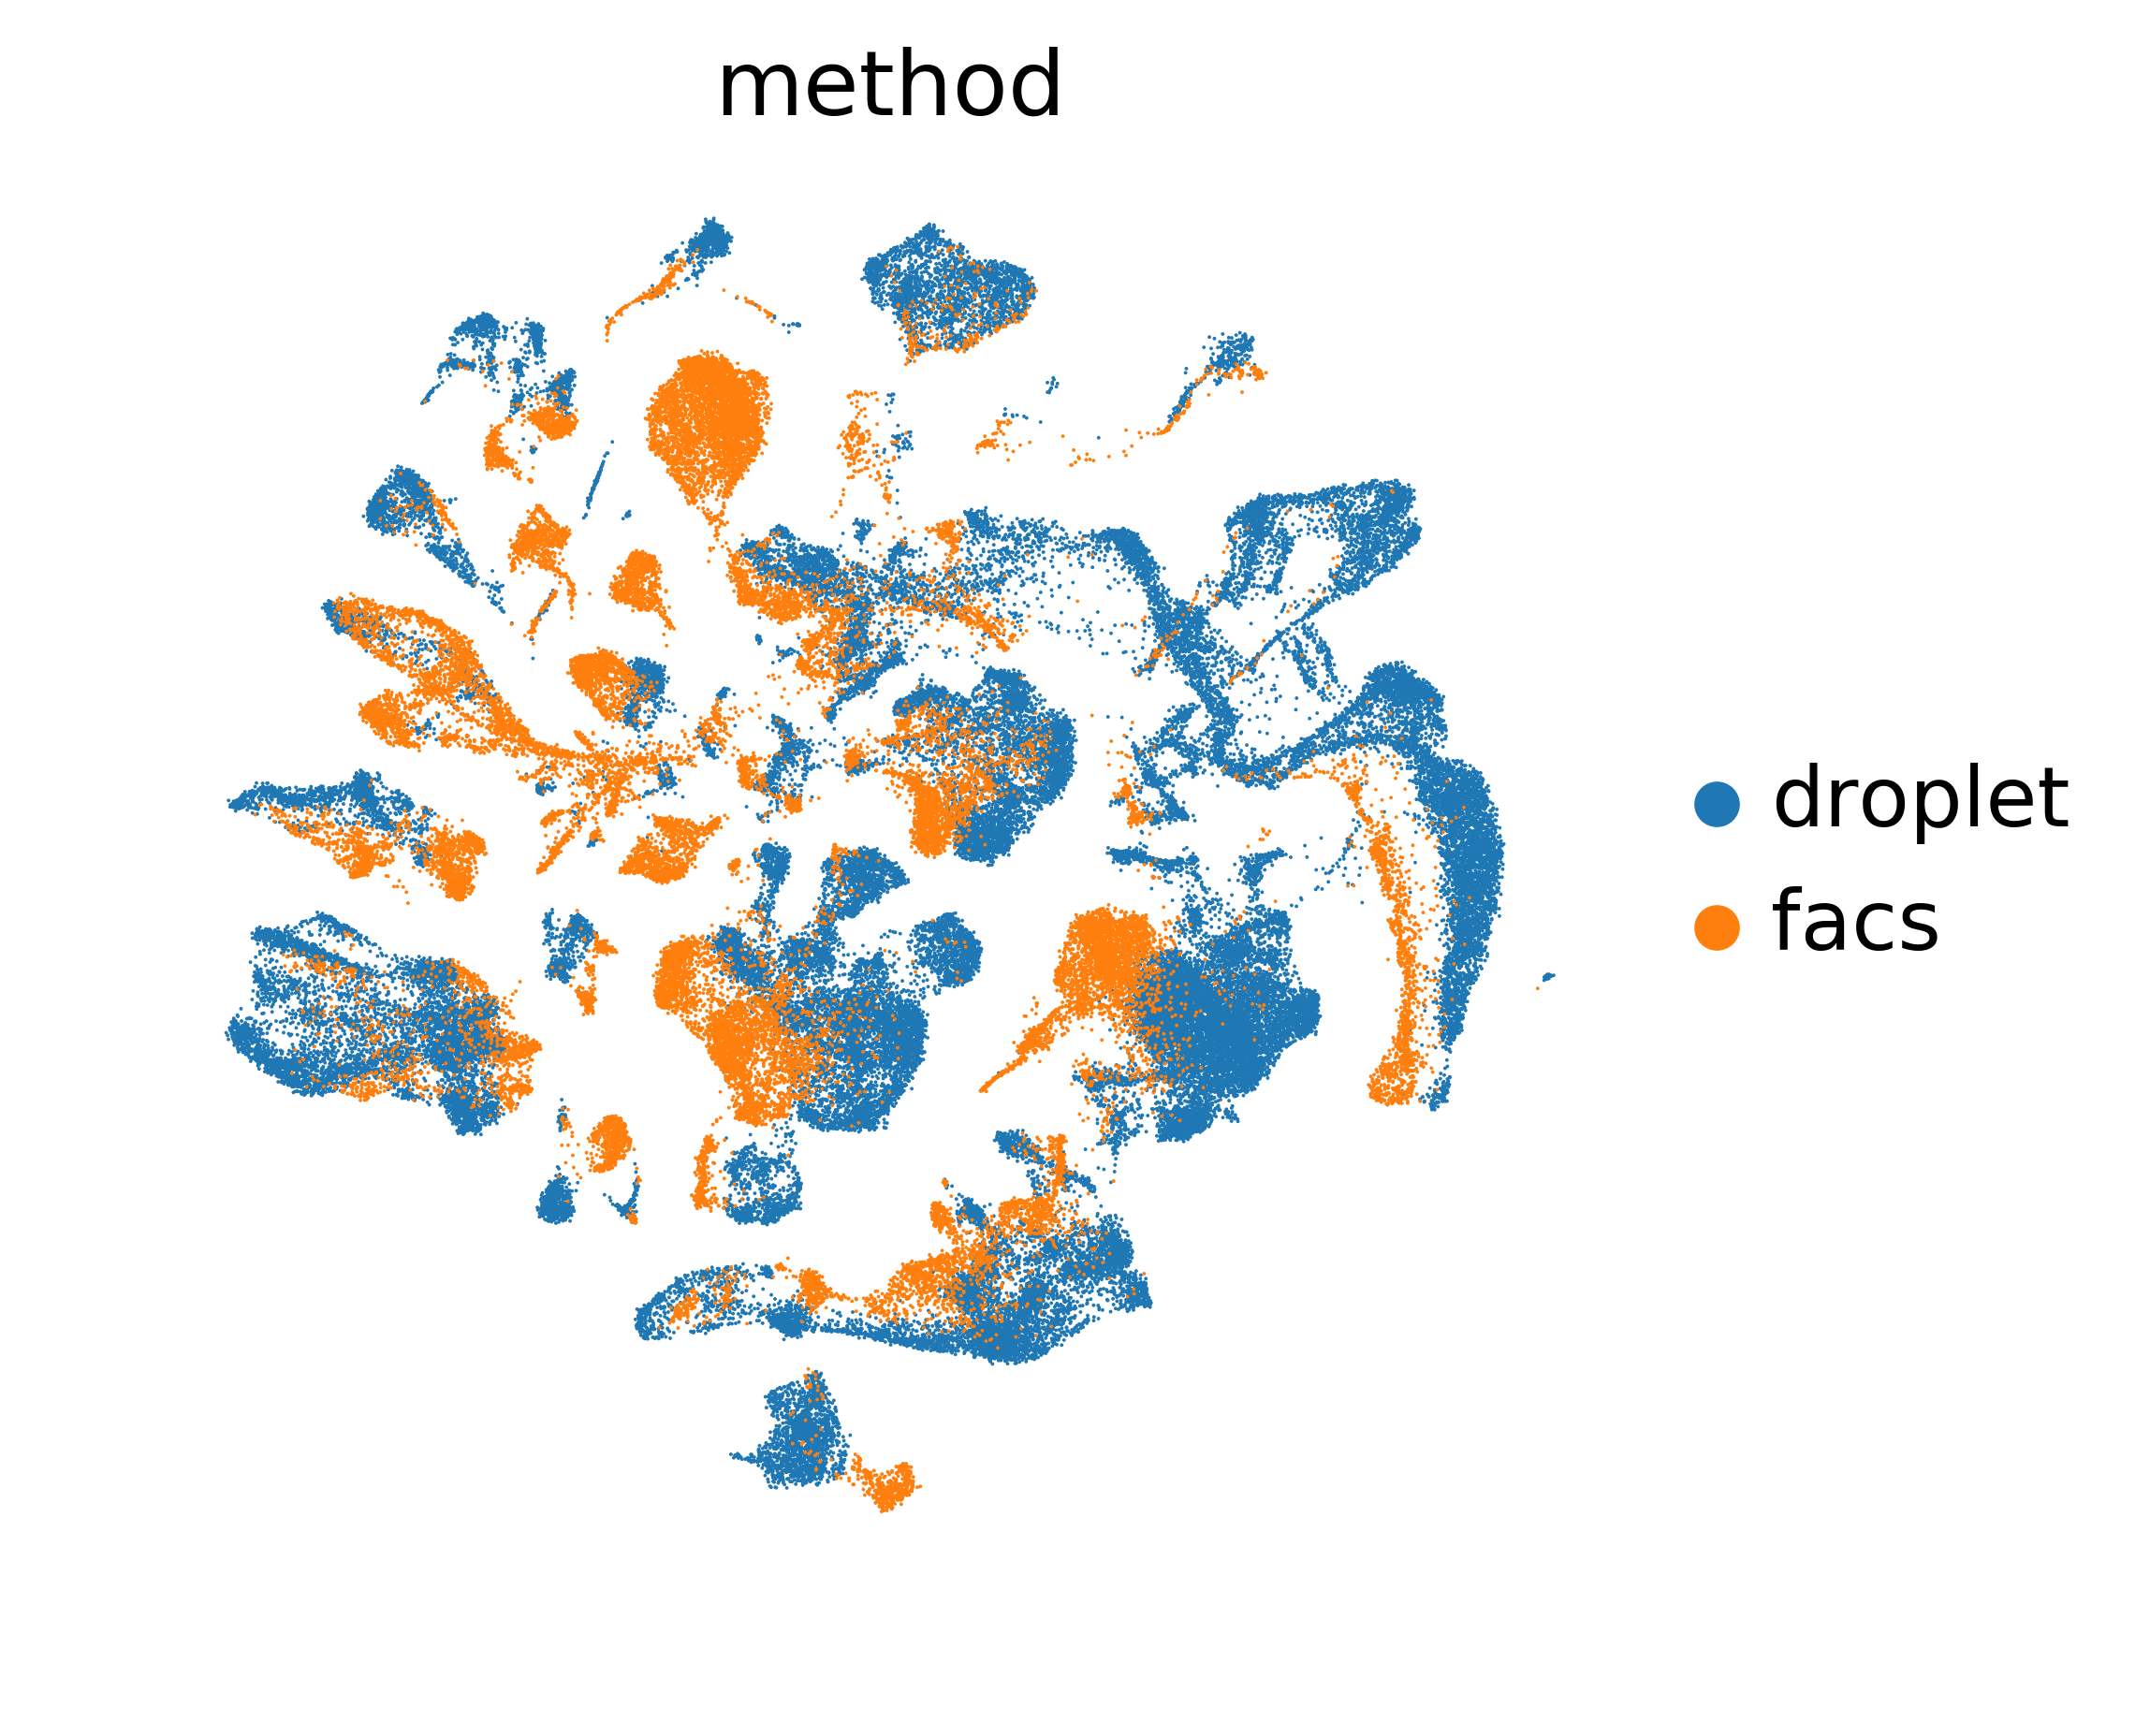

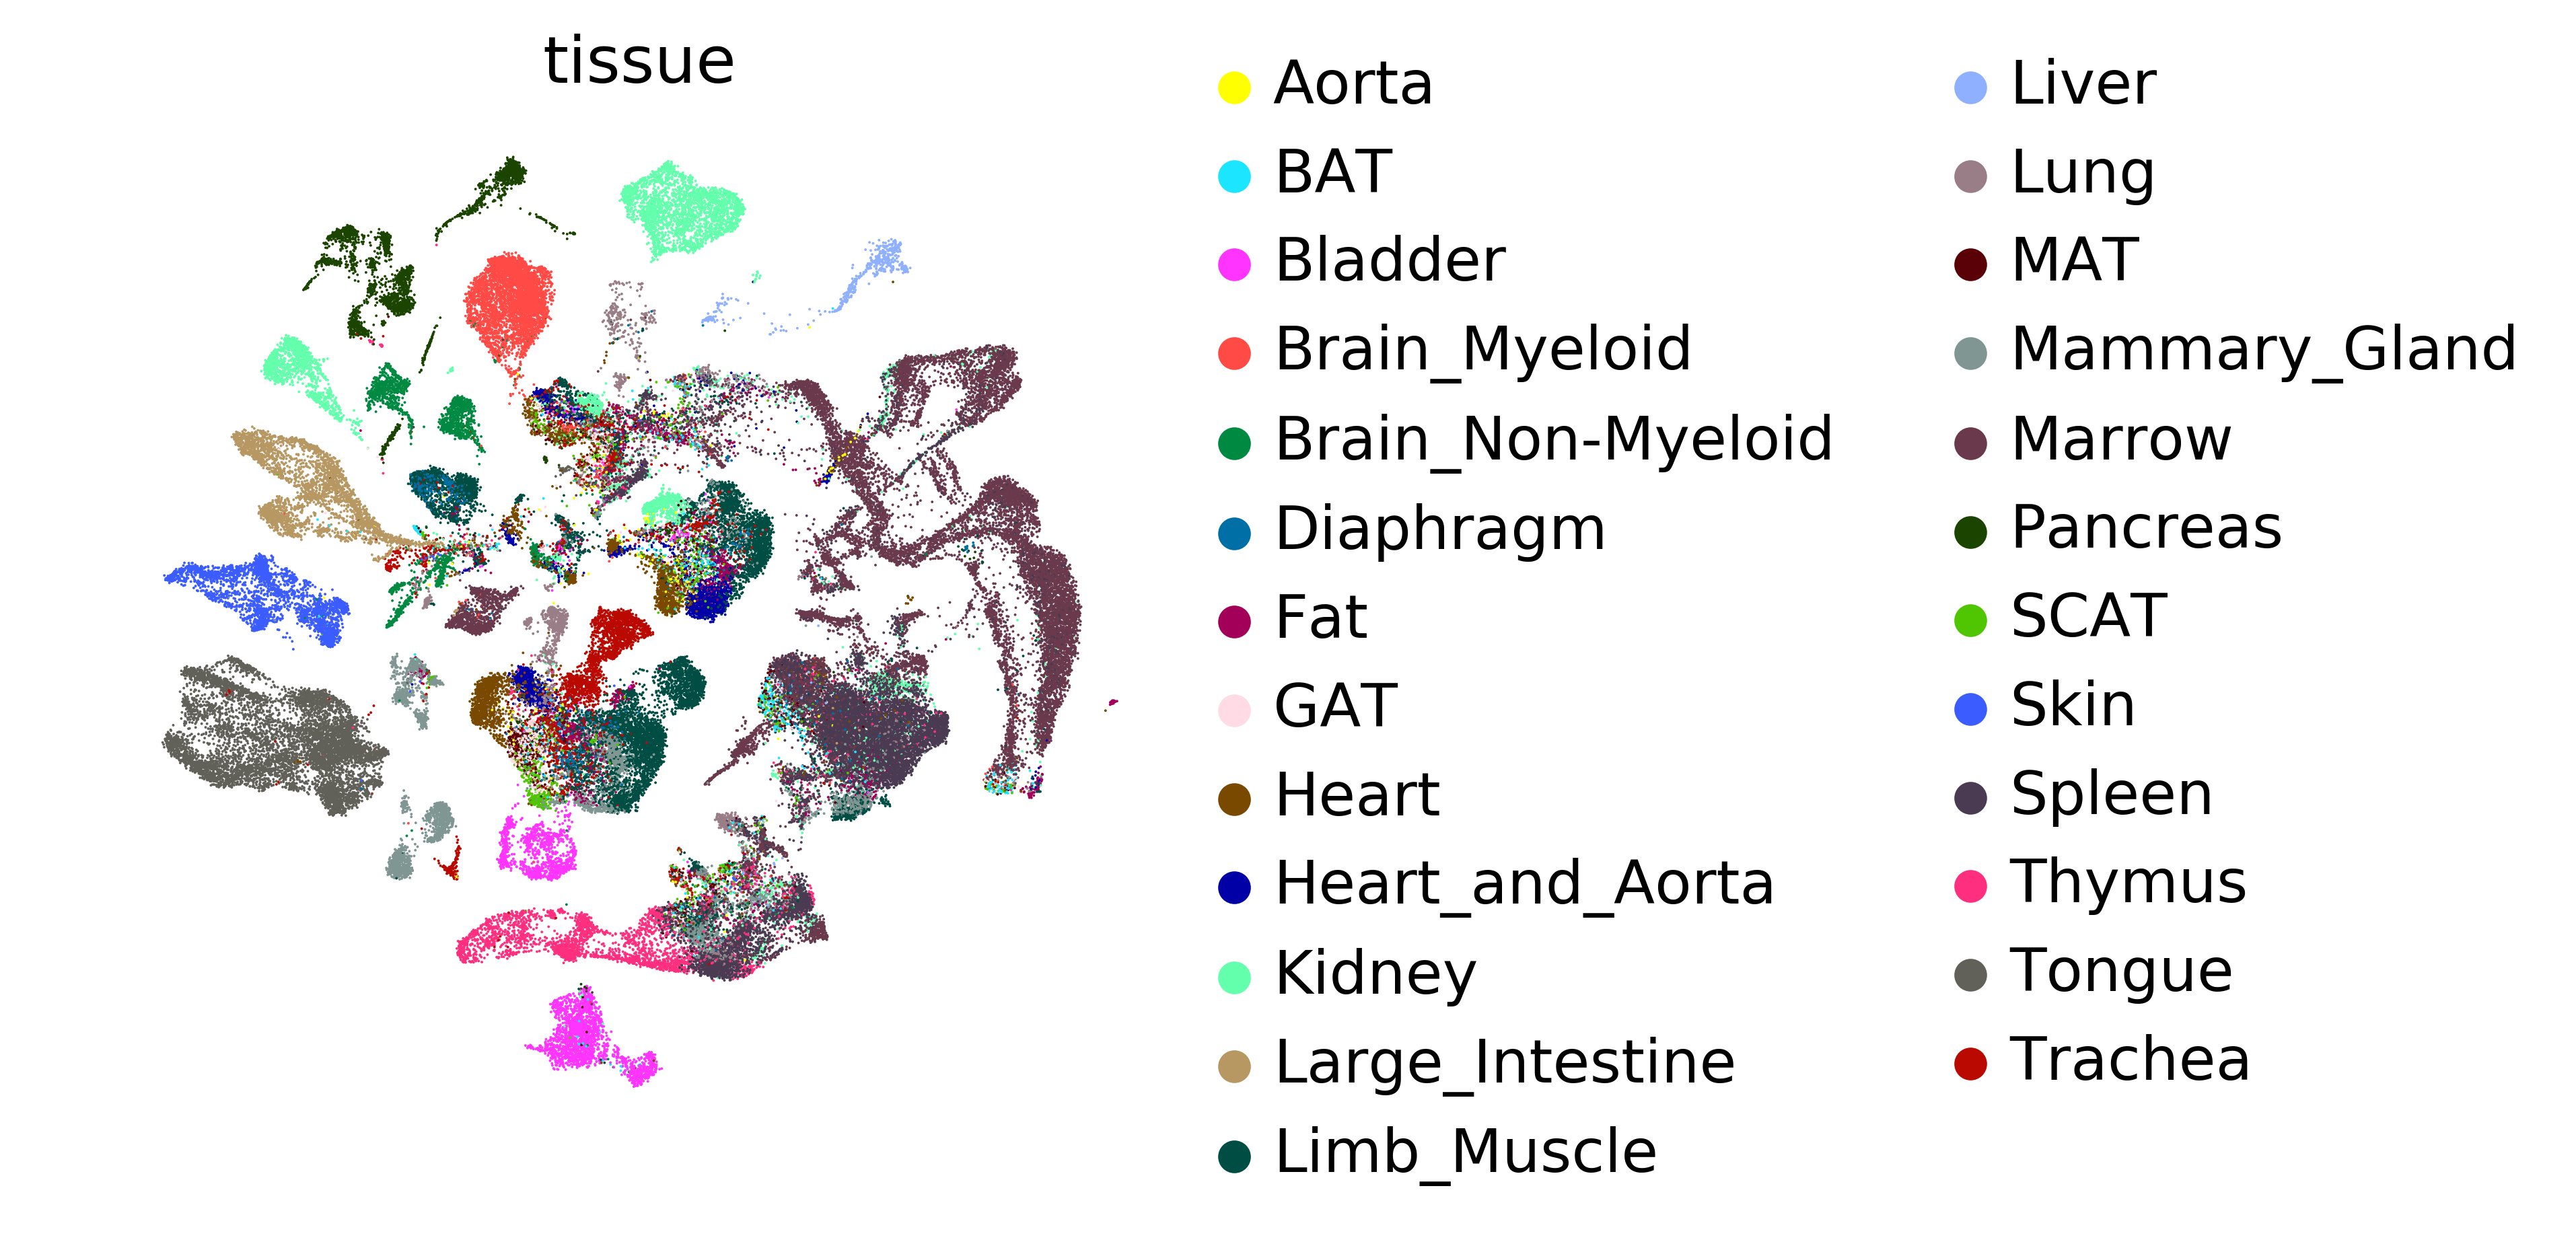

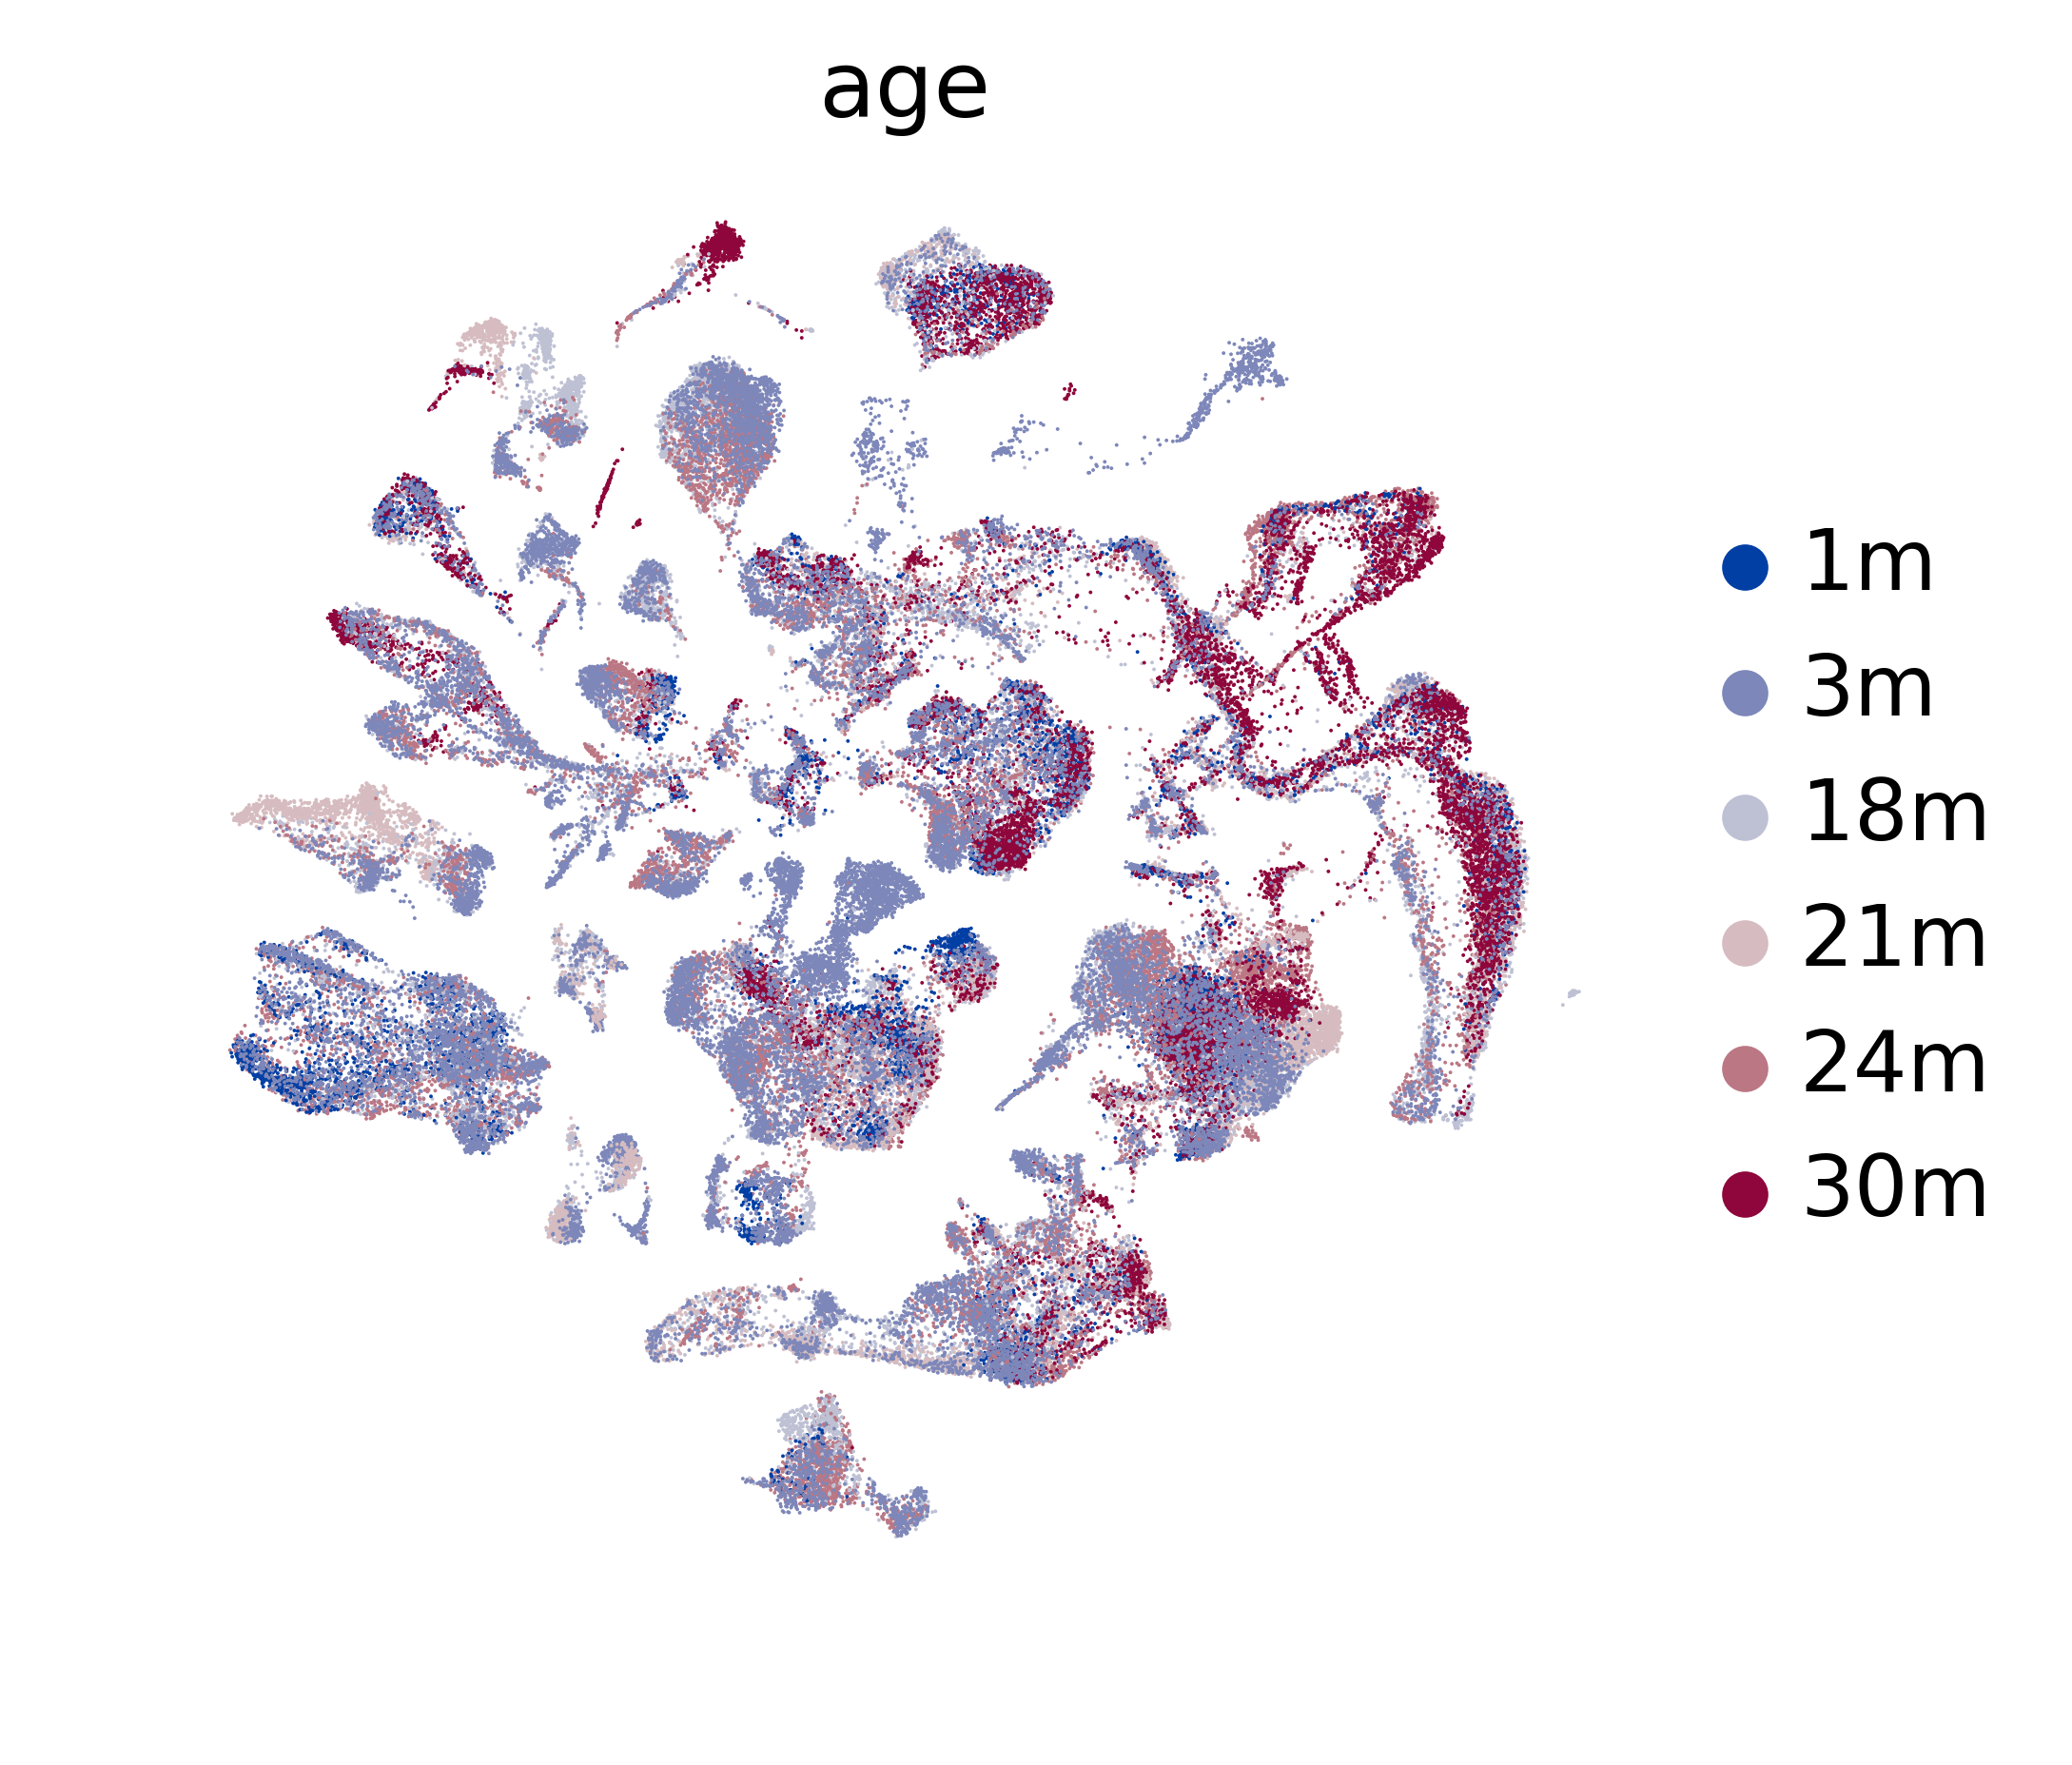

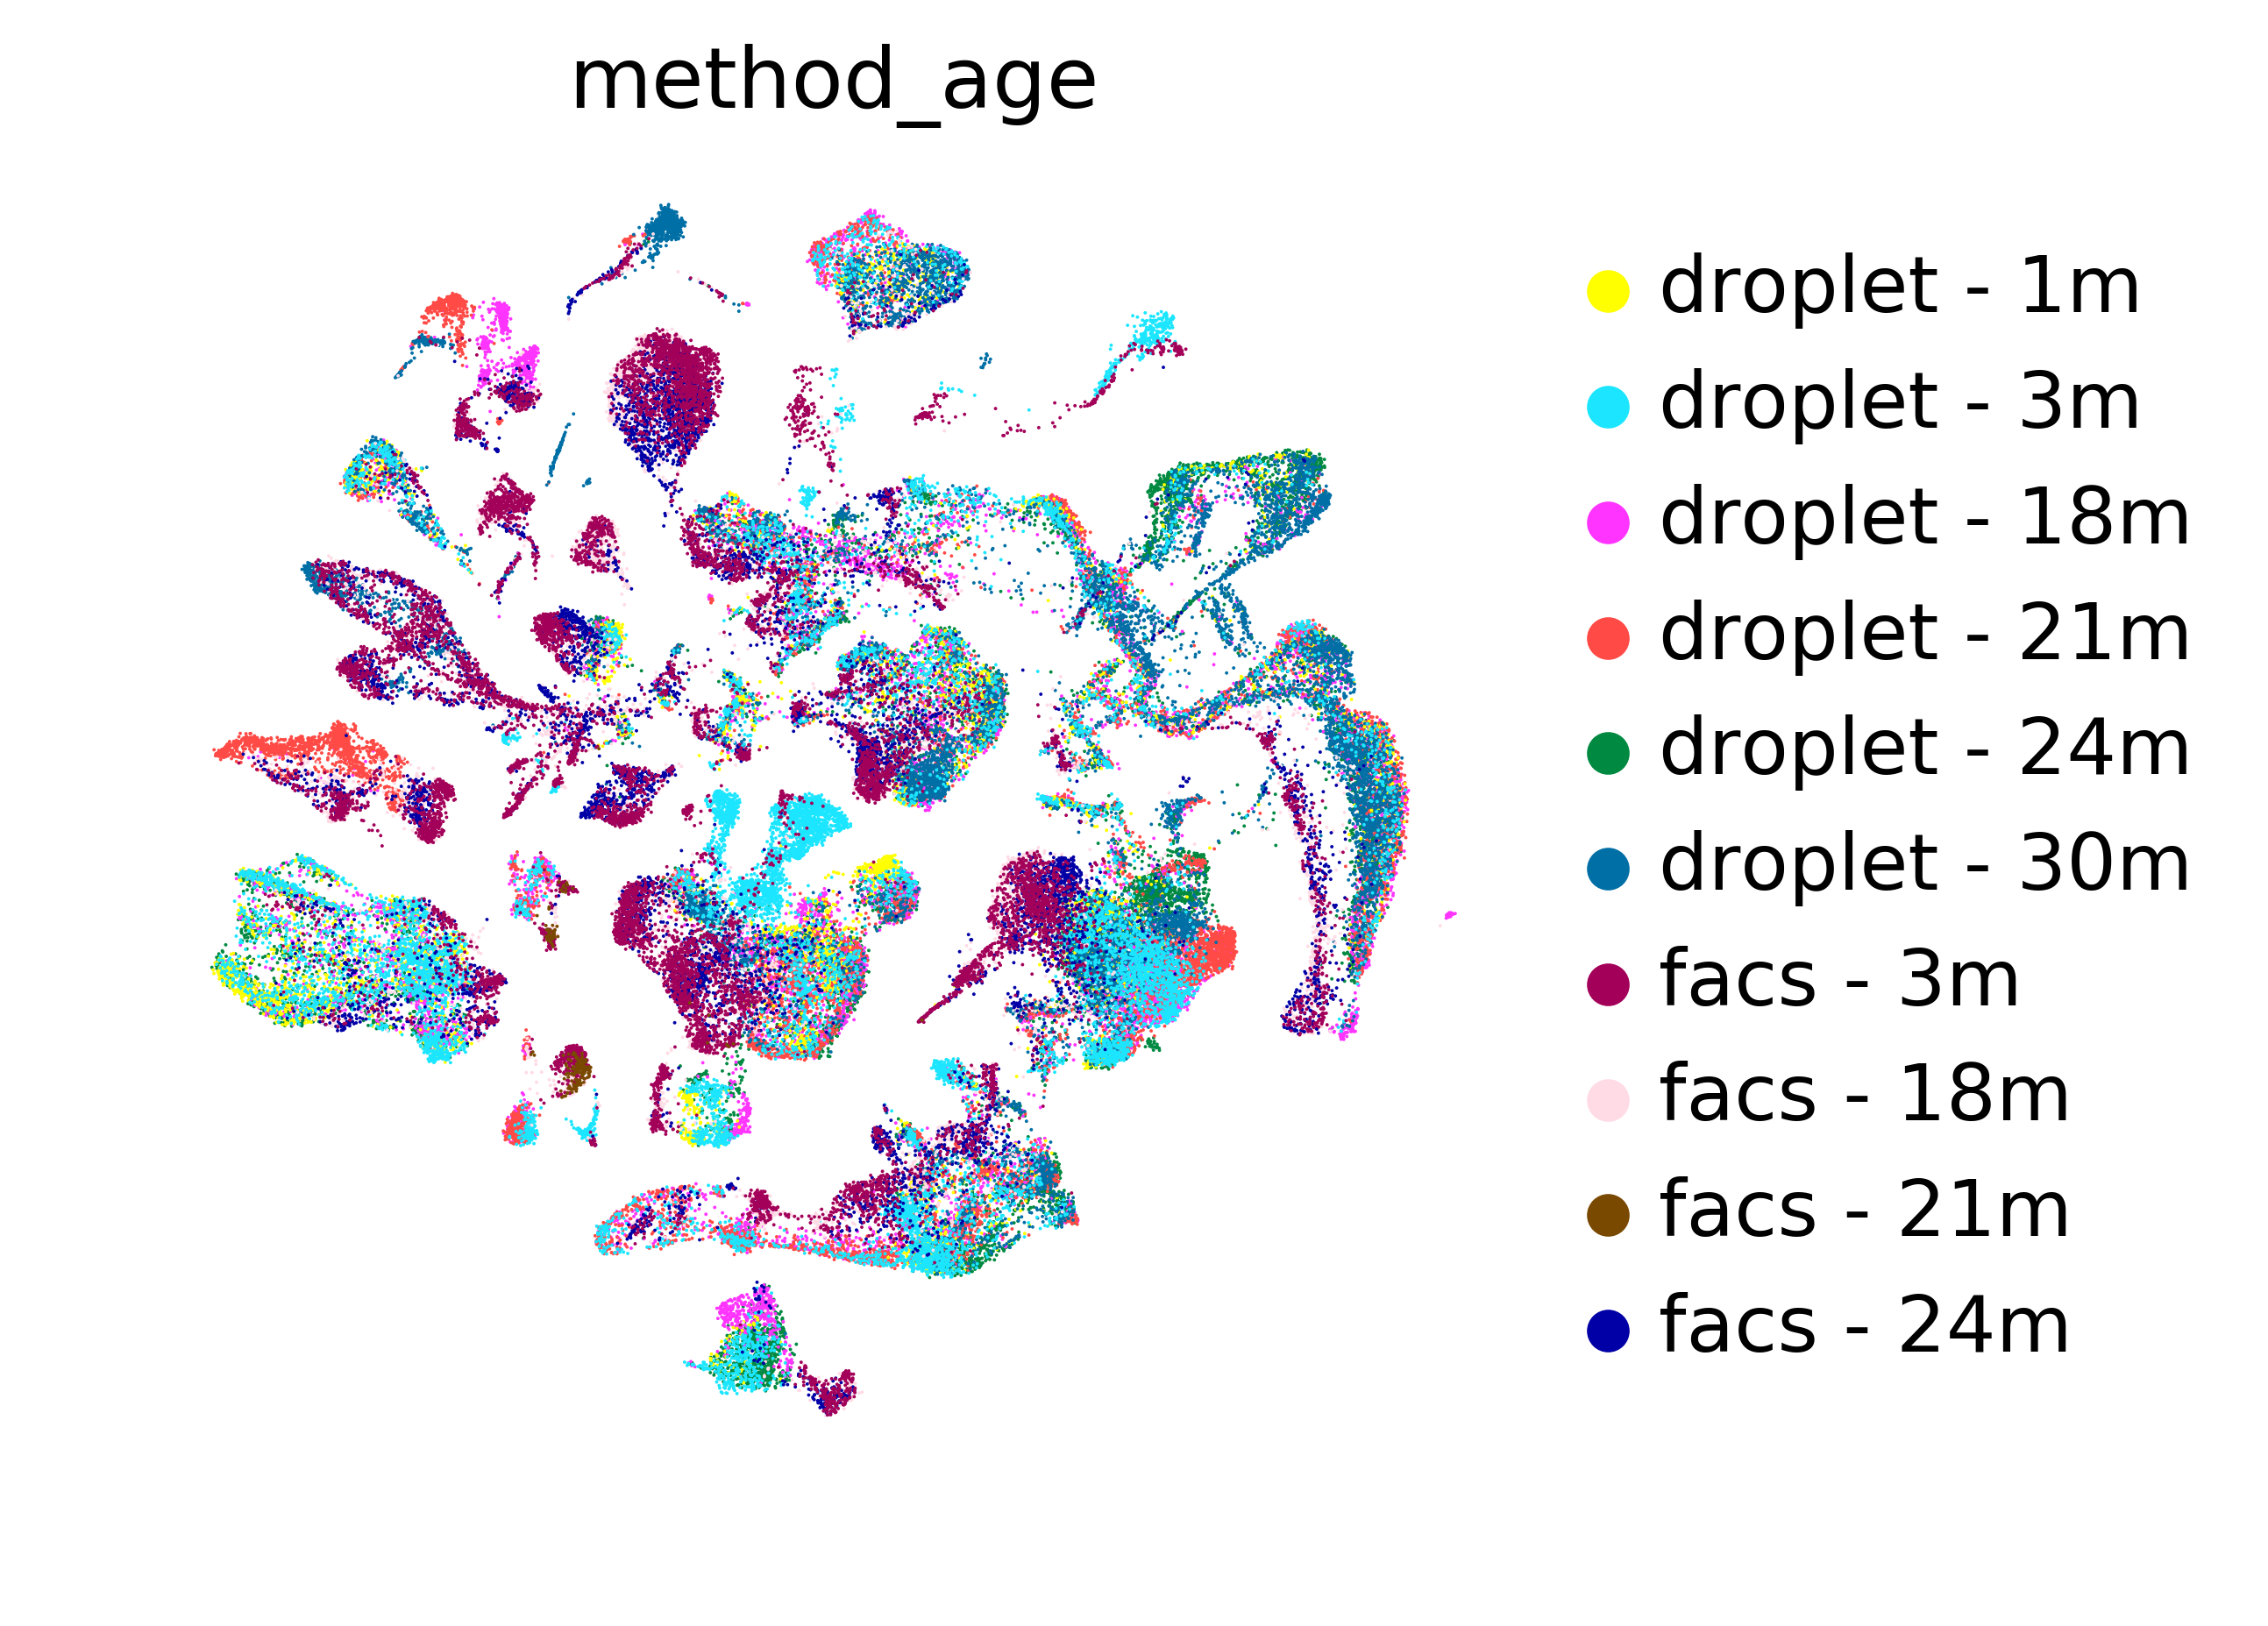

In [10]:
sc.pl.umap(adata, color='method', frameon=False, save='_original_method.pdf')
sc.pl.umap(adata, color='tissue', frameon=False, save='_original_tissue.pdf', palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(adata, color='age', frameon=False, save='_original_age.pdf', palette=sc.pl.palettes.zeileis_28)
sc.pl.umap(adata, color='method_age', frameon=False, save=f'_original_method_age.pdf', palette=sc.pl.palettes.godsnot_102)

In [9]:
adata = sc.read("./data/tabula_senis/tabula_senis_normalized_all.h5ad")
adata

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'method_tissue', 'method_age'
    var: 'n_cells-0', 'n_cells-1'

In [10]:
adata = hvg_batch(adata, "method_age", target_genes=2000, adataOut=True)
adata

Using 352 HVGs from full intersect set
Using 410 HVGs from n_batch-1 set
Using 288 HVGs from n_batch-2 set
Using 233 HVGs from n_batch-3 set
Using 321 HVGs from n_batch-4 set
Using 254 HVGs from n_batch-5 set
Using 142 HVGs from n_batch-6 set
Using 2000 HVGs


AnnData object with n_obs × n_vars = 356213 × 2000 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'method_tissue', 'method_age'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [11]:
adata.write_h5ad("./data/tabula_senis/tabula_senis_normalized_hvg_all.h5ad")

In [12]:
tabula_muris = adata[adata.obs['method_age'].isin(['droplet - 3m', 'facs - 3m'])]
tabula_muris

View of AnnData object with n_obs × n_vars = 90120 × 2000 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'method_tissue', 'method_age'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [13]:
tabula_senis = adata[~adata.obs['method_age'].isin(['droplet - 3m', 'facs - 3m'])]
tabula_senis

View of AnnData object with n_obs × n_vars = 266093 × 2000 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'method_tissue', 'method_age'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [14]:
subsampled_senis = subsample_selection(tabula_senis, "tissue", 0.4)
subsampled_senis

AnnData object with n_obs × n_vars = 106428 × 2000 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [15]:
subsampled_senis.concatenate(tabula_muris).write_h5ad("./data/tabula_senis_muris/tabula_senis_muris_normalized_hvg_subsampled.h5ad")

... storing 'FACS.selection' as categorical
... storing 'age' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'free_annotation' as categorical
... storing 'method' as categorical
... storing 'method_age' as categorical
... storing 'method_tissue' as categorical
... storing 'mouse.id' as categorical
... storing 'sex' as categorical
... storing 'subtissue' as categorical
... storing 'tissue' as categorical
... storing 'tissue_free_annotation' as categorical
